In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, filters, img_as_ubyte, exposure
import pandas as pd

# Define data and output directories
data_directory = os.path.join(os.getcwd(), "data") # Set your data directory here
output_directory = os.path.join(data_directory, "results")  # Results folder inside data directory
os.makedirs(output_directory, exist_ok=True)

print("Current Directory:", os.getcwd())
print("Data Directory:", data_directory)
print("Output Directory:", output_directory)


Current Directory: C:\Users\fek64mu\Desktop\Projects\TIFocus
Data Directory: C:\Users\fek64mu\Desktop\Projects\TIFocus\data
Output Directory: C:\Users\fek64mu\Desktop\Projects\TIFocus\data\results


In [2]:
# Load the multi-frame TIFF (Z-Stack)
def load_tif_zstack(file_path):
    img_stack = io.imread(file_path)
    print(f"Loaded image stack with shape: {img_stack.shape}")  # (Z, Y, X) or (Z, Y, X, C) if multichannel
    return img_stack

In [3]:
# Compute Laplacian variance for each Z-slice
def compute_laplacian_variance(img_stack):
    variances = [np.var(filters.laplace(img_stack[z])) for z in range(img_stack.shape[0])]
    return variances

In [4]:
# Analyze stack and compute statistics
def analyze_stack(img_stack):
    stats = []
    for z in range(img_stack.shape[0]):
        slice_mean = np.mean(img_stack[z])
        slice_std = np.std(img_stack[z])
        stats.append({'Slice': z, 'Mean': slice_mean, 'Std': slice_std})
    return pd.DataFrame(stats)

In [5]:
# Visualize the slice with highest Laplacian variance
def show_highest_variance_slice(img_stack, variances, file_name):
    results_path = os.path.join(output_directory, f"{file_name}_analysis.png")
    csv_path = os.path.join(output_directory, f"{file_name}_analysis.csv")
    max_variance_index = np.argmax(variances)

    # Analyze stack
    stack_stats = analyze_stack(img_stack)
    stack_stats['Laplacian_Variance'] = variances

    # Save results to CSV
    stack_stats.to_csv(csv_path, index=False)

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(len(variances)), variances, marker='o', linestyle='-')
    plt.xlabel("Z-Slice Number")
    plt.ylabel("Laplacian Variance")
    plt.title("Laplacian Variance across Z-Slices")
    plt.grid(True)
    plt.xlim(0, len(variances))

    plt.subplot(1, 2, 2)
    highest_variance_slice_8bit = img_as_ubyte(img_stack[max_variance_index])
    normalized_slice = (highest_variance_slice_8bit - highest_variance_slice_8bit.min()) / (highest_variance_slice_8bit.max() - highest_variance_slice_8bit.min())
    plt.imshow(normalized_slice, cmap='gray')
    plt.title(f'Slice with Highest Variance (Z-Slice {max_variance_index})')
    plt.axis('off')

    # ===== debug =====
    print(f'Filename-{file_name}, has a min. value: {highest_variance_slice_8bit.min()}, a max. value: {highest_variance_slice_8bit.max()}')

    plt.tight_layout()
    plt.savefig(results_path)
    plt.show()
    plt.close()

    print(f"The slice with the highest Laplacian variance is Z-Slice {max_variance_index}")
    print(f"Results saved to {csv_path}")


Loaded image stack with shape: (41, 3200, 3200)
Filename-KEIO_Plate61 Well D6 DIA 5ms, has a min. value: 117, a max. value: 173


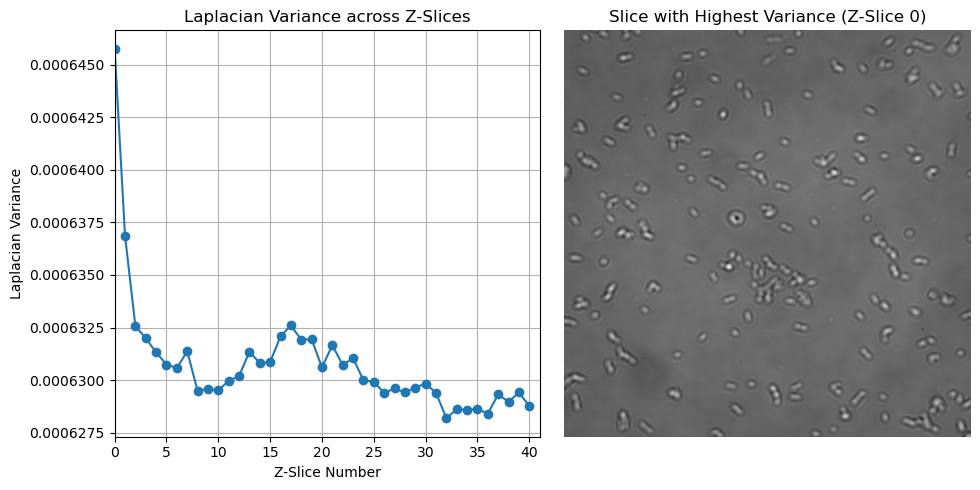

The slice with the highest Laplacian variance is Z-Slice 0
Results saved to C:\Users\fek64mu\Desktop\Projects\TIFocus\data\results\KEIO_Plate61 Well D6 DIA 5ms_analysis.csv


In [6]:
# Example usage
file_path = r"L:\43-RVZ\AIMicroscopy\Mitarbeiter\2_Data\1_NikonTi2\FK_P001_EX004_2025_03_05 60x 1.5x KEIO Plate61 DIC Angle\TIF\KEIO_Plate61 Well D6 DIA 5ms.tif"
file_name = os.path.basename(file_path).split('.')[0]
img_stack = load_tif_zstack(file_path)
variances = compute_laplacian_variance(img_stack)
show_highest_variance_slice(img_stack, variances, file_name)

In [7]:
# Main analysis loop
def analyze_tif_stacks(data_directory):
    for filename in os.listdir(data_directory):
        if filename.endswith(".tif") or filename.endswith(".tiff"):
            file_path = os.path.join(data_directory, filename)
            print(f"Analyzing: {filename}")
            # Load the image stack
            img_stack = load_tif_zstack(file_path)
            # Compute Laplacian variance
            variances = compute_laplacian_variance(img_stack)
            # Show and save the slice with the highest variance
            show_highest_variance_slice(img_stack, variances, file_name=os.path.splitext(filename)[0])

Analyzing: WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series01.tif
Loaded image stack with shape: (19, 3200, 3200)
Filename-WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series01, has a min. value: 43, a max. value: 255


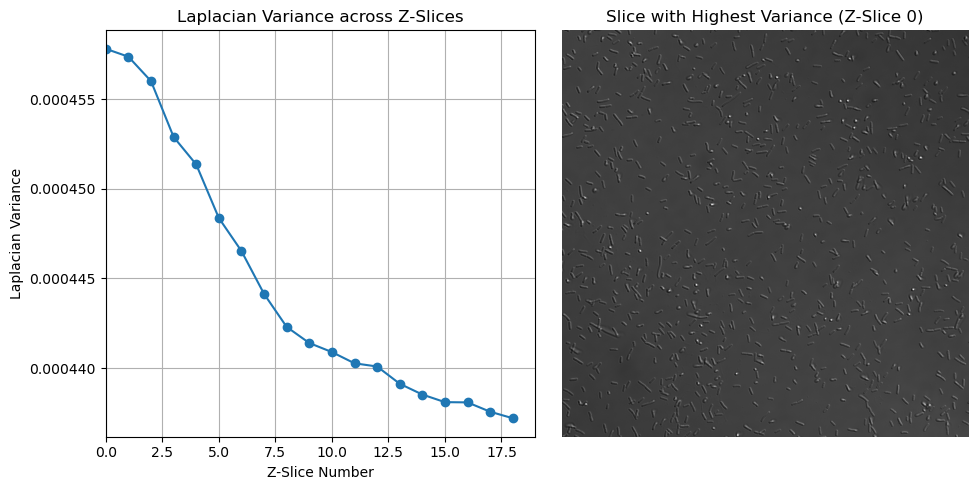

The slice with the highest Laplacian variance is Z-Slice 0
Results saved to C:\Users\fek64mu\Desktop\Projects\TIFocus\data\results\WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series01_analysis.csv
Analyzing: WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series02.tif
Loaded image stack with shape: (19, 3200, 3200)
Filename-WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series02, has a min. value: 44, a max. value: 255


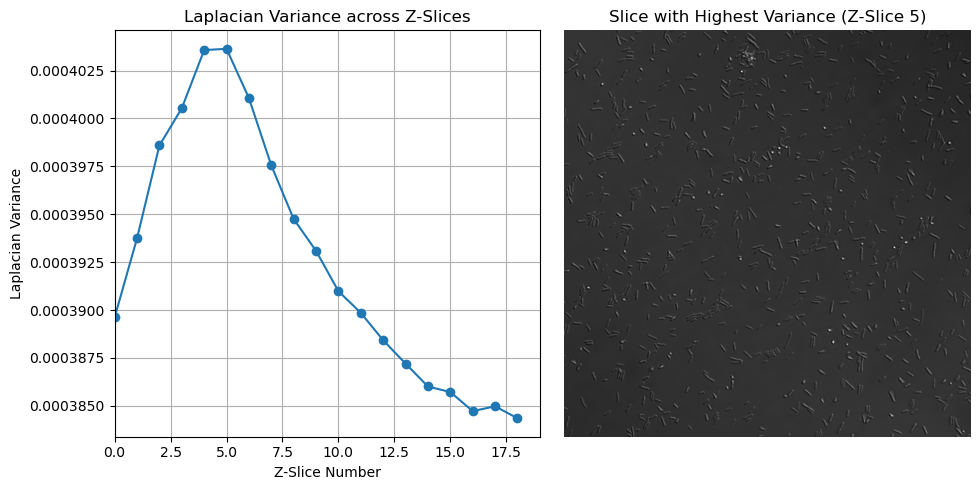

The slice with the highest Laplacian variance is Z-Slice 5
Results saved to C:\Users\fek64mu\Desktop\Projects\TIFocus\data\results\WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series02_analysis.csv
Analyzing: WellA01_ChannelCam-DIA DIC Master_1_Seq0000_series03.tif
Loaded image stack with shape: (19, 3200, 3200)


In [ ]:
analyze_tif_stacks(data_directory)